In [31]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [32]:
df = pd.read_csv(r'data\Bold_744H-10_31-11_07.csv')
df['Deviation'] = (df['Inj Gas Meter Volume Setpoint'] -
                   df['Inj Gas Meter Volume Instantaneous']) / df['Inj Gas Meter Volume Setpoint']
print(df['Deviation'].describe())

count    675.000000
mean       0.045210
std        0.179697
min       -0.081525
25%       -0.031819
50%        0.001721
75%        0.045543
max        1.000000
Name: Deviation, dtype: float64


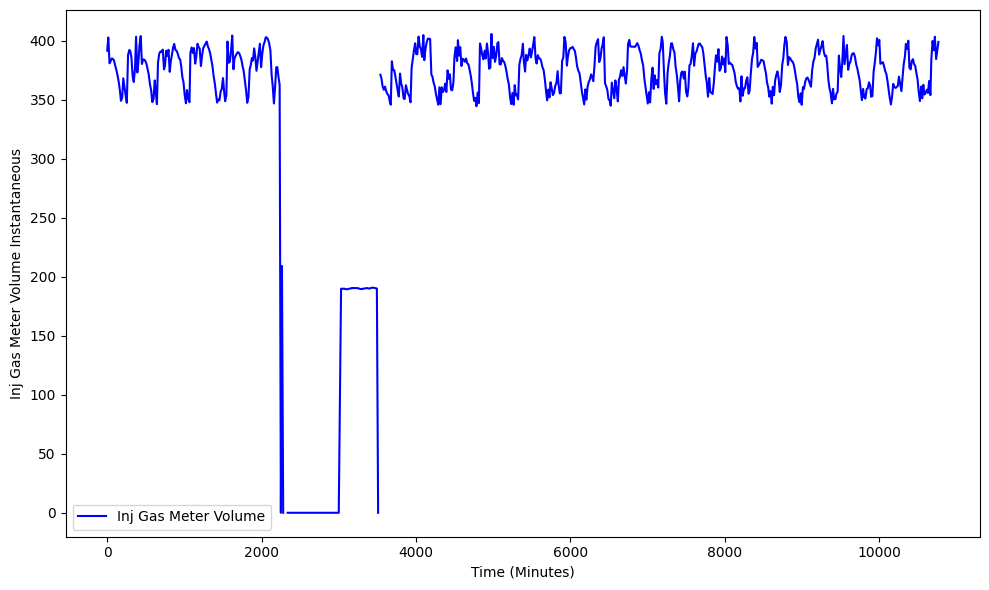

In [33]:
df['Time'] = pd.to_datetime(df['Time'], format='%m/%d/%Y %I:%M:%S %p')
df['Time in Minutes'] = (df['Time'] - df['Time'].iloc[0]).dt.total_seconds() / 60

# Now, plot the data with 'Time in Minutes' on the x-axis
plt.figure(figsize=(10, 6))
plt.plot(df['Time in Minutes'], df['Inj Gas Meter Volume Instantaneous'], label='Inj Gas Meter Volume', color='b')


# Add labels and title
plt.xlabel('Time (Minutes)')
plt.ylabel('Inj Gas Meter Volume Instantaneous')
plt.legend()
plt.tight_layout()

plt.show()

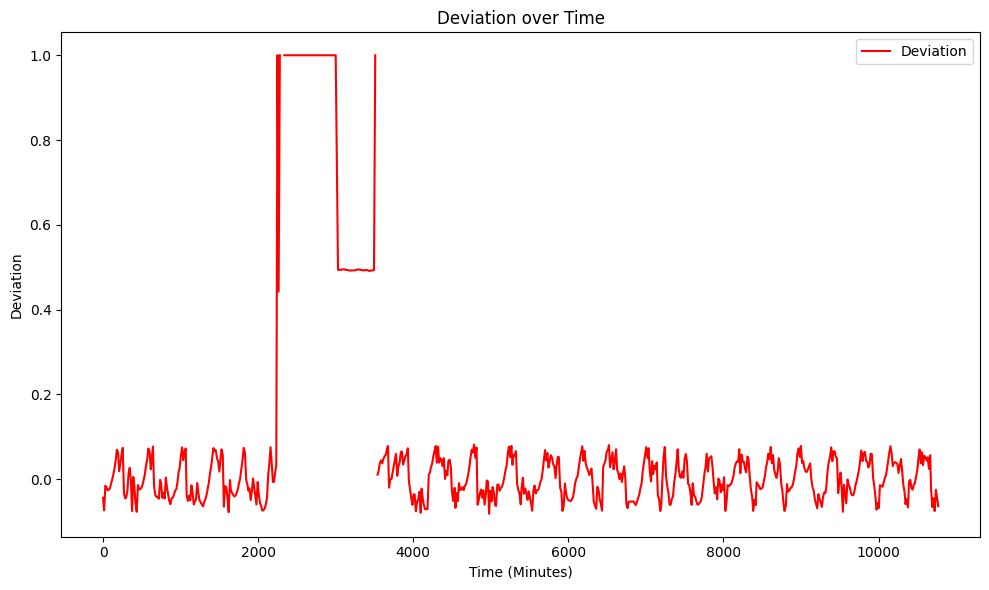

In [34]:
plt.figure(figsize=(10, 6))
plt.plot(df['Time in Minutes'], df['Deviation'], label='Deviation', color='r', linestyle='-')

# Add labels and title
plt.xlabel('Time (Minutes)')
plt.ylabel('Deviation')
plt.title('Deviation over Time')

# Add legend
plt.legend()

# Adjust layout for better spacing
plt.tight_layout()

# Show the plot
plt.show()

In [36]:
# Define thresholds based on data statistics
instantaneous_drop_threshold = -10  # Slightly below 25th percentile
deviation_increase_threshold = 0.15  # Above 75th percentile

# Calculate rate of change
df['Inj Gas Meter Volume Change'] = df['Inj Gas Meter Volume Instantaneous'].diff()
df['Deviation Change'] = df['Deviation'].diff()

# Identify where both conditions are met
df['Significant Change'] = (
    (df['Inj Gas Meter Volume Change'] < instantaneous_drop_threshold) &
    (df['Deviation Change'] > deviation_increase_threshold)
)

# Find time intervals for significant changes
intervals = []
start_time = None

for index, row in df.iterrows():
    if row['Significant Change']:
        if start_time is None:  # Start of a new interval
            start_time = row['Time in Minutes']
    else:
        if start_time is not None:  # End of the current interval
            end_time = row['Time in Minutes']
            intervals.append((start_time, end_time))
            start_time = None

# Handle case where the interval extends to the last row
if start_time is not None:
    intervals.append((start_time, df['Time in Minutes'].iloc[-1]))

# Output results
if intervals:
    print("Significant changes detected in the following time intervals:")
    for start, end in intervals:
        print(f"From {start:.2f} to {end:.2f} minutes")
else:
    print("No significant changes detected in any time intervals.")


Significant changes detected in the following time intervals:
From 2250.00 to 2264.00 minutes
From 2280.00 to 2296.00 minutes
From 3510.00 to 3524.00 minutes


In [37]:
df.columns

Index(['Time', 'Inj Gas Meter Volume Instantaneous',
       'Inj Gas Meter Volume Setpoint', 'Inj Gas Valve Percent Open',
       'Deviation', 'Time in Minutes', 'Inj Gas Meter Volume Change',
       'Deviation Change', 'Significant Change'],
      dtype='object')

In [38]:
df = df.dropna(subset=['Deviation Change'])
df = df.dropna(subset=['Inj Gas Meter Volume Change'])
features = df[['Inj Gas Meter Volume Change', 'Deviation Change']]
from sklearn.ensemble import IsolationForest

In [39]:
# Initialize the Isolation Forest model
iso_forest = IsolationForest(contamination=0.005, random_state=42)

# Fit the model on the features (Inj Gas Meter Volume Change and Deviation Change)
iso_forest.fit(features)

# Predict anomalies (1 is normal, -1 is anomaly)
df['Anomaly'] = iso_forest.predict(features)

# Show the rows that are detected as anomalies
anomalies = df[df['Anomaly'] == -1]

# Print out the anomalies
print("Detected anomalies:")
print(anomalies[['Time in Minutes', 'Inj Gas Meter Volume Change', 'Deviation Change']])


Detected anomalies:
     Time in Minutes  Inj Gas Meter Volume Change  Deviation Change
150           2250.0                   -362.60430          0.966945
151           2264.0                    209.00475         -0.557346
152           2280.0                   -209.00475          0.557346
165           3030.0                    189.80460         -0.506146


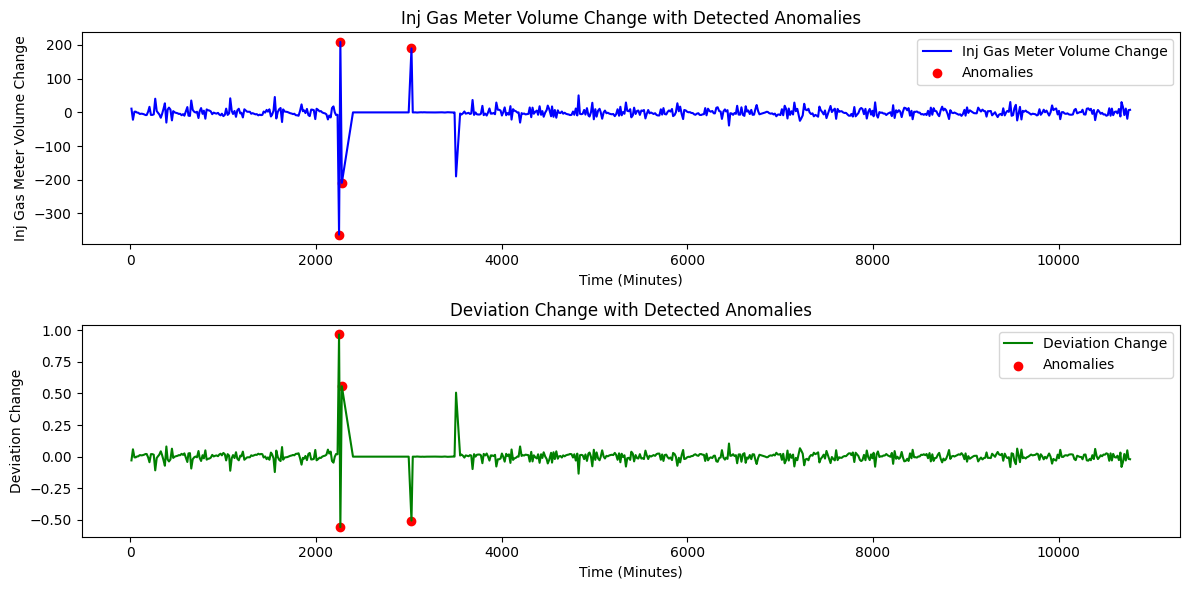

In [30]:
import matplotlib.pyplot as plt

# Plot the volume change and deviation change over time
plt.figure(figsize=(12, 6))

plt.subplot(2, 1, 1)
plt.plot(df['Time in Minutes'], df['Inj Gas Meter Volume Change'], label='Inj Gas Meter Volume Change', color='b')
plt.scatter(anomalies['Time in Minutes'], anomalies['Inj Gas Meter Volume Change'], color='r', label='Anomalies')
plt.xlabel('Time (Minutes)')
plt.ylabel('Inj Gas Meter Volume Change')
plt.title('Inj Gas Meter Volume Change with Detected Anomalies')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(df['Time in Minutes'], df['Deviation Change'], label='Deviation Change', color='g')
plt.scatter(anomalies['Time in Minutes'], anomalies['Deviation Change'], color='r', label='Anomalies')
plt.xlabel('Time (Minutes)')
plt.ylabel('Deviation Change')
plt.title('Deviation Change with Detected Anomalies')
plt.legend()

plt.tight_layout()
plt.show()
